In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bintrees import FastRBTree
from sklearn.preprocessing import  Normalizer
snapCol = ['code', 'trdTime', 'recvTime', 'mthPrc', 'cumVol', 'turnover', 'cumCnt',
       'bidPrc10', 'bidPrc9', 'bidPrc8', 'bidPrc7', 'bidPrc6', 'bidPrc5',
       'bidPrc4', 'bidPrc3', 'bidPrc2', 'bidPrc1', 'askPrc1', 'askPrc2',
       'askPrc3', 'askPrc4', 'askPrc5', 'askPrc6', 'askPrc7', 'askPrc8',
       'askPrc9', 'askPrc10', 'bidVol10', 'bidVol9', 'bidVol8', 'bidVol7',
       'bidVol6', 'bidVol5', 'bidVol4', 'bidVol3', 'bidVol2', 'bidVol1',
       'askVol1', 'askVol2', 'askVol3', 'askVol4', 'askVol5', 'askVol6',
       'askVol7', 'askVol8', 'askVol9', 'askVol10']
def getMkDataMult(dataStreamMap:dict,sortBy="idOrd"):
    # dataStreamMap = {ins: getMkData(*readH5Cache(ins, qDate)) for ins in insSet}
    dataDict = {}
    reformData = {}
    orderSortBy,transSortBy = 8,8
    if sortBy=="recvTime":
        orderSortBy,transSortBy = 3,3
    if sortBy=="BizIndex":
        orderSortBy, transSortBy = 10, 12
    snapLocD = {}
    maxSnapLenD = {}

    for key,datas in dataStreamMap.items():

        orderDf, transDf, snapDf = datas
        if len(orderDf)<1:
            continue
        if len(transDf)<1:
            return

        if len(snapDf)>0:
            snapDf = snapDf.sort_values("trdTime")
            snapDf = snapDf[snapCol]
        orderQ = np.insert(orderDf.values.astype("int64"), 0, 0, axis=1)
        if len(str(orderQ[0,2]))<10: #trdTime
            orderQ[:, 2] =orderQ[:, 2]*1e6
        if len(str(orderQ[0,3]))<10: #recvTime
            orderQ[:, 3] =orderQ[:, 3]*1e6


        transQ = np.insert(transDf.values.astype("int64"), 0, 1, axis=1)
        if len(str(transQ[0,2]))<10:
            transQ[:, 2] =transQ[:, 2]*1e6
        if len(str(transQ[0,3]))<10:
            transQ[:, 3] =transQ[:, 3]*1e6



        snapQ =  np.insert(snapDf.values.astype("int64"), 0, 2, axis=1)

        if len(snapQ>1):
            if len(str(snapQ[0,2]))<10:
                snapQ[:, 2] = snapQ[:, 2] * 1e6
            if len(str(snapQ[0, 3])) < 10:
                snapQ[:, 3] = snapQ[:, 3] * 1e6

        for i in range(len(orderQ)):
            dataDict[(orderQ[i,orderSortBy],key)] = key,0, i

        for i in range(len(transQ)):
            dataDict[(transQ[i,transSortBy],key)]= key,1, i

        reformData[key] = orderQ,transQ,snapQ
        if len(snapQ)>0:
            snapLocD[key] = 0
            maxSnapLenD[key] = len(snapQ)


    #

    # lastID = min(orderQ[-1, -1],transQ[-1,-3])
    # maxOrderLen = len(orderQ)
    # maxTransLen = len(transQ)
    # maxSnapLen = len(snapQ)
    # timeLine = 0
    sortedKeys = sorted(dataDict.keys())

    for i in sortedKeys:

        key,dtype_i,dLoc_i = dataDict[i]

        if dtype_i==0:
            data_i = reformData[key][0][dLoc_i]
        if  dtype_i==1:
            data_i = reformData[key][1][dLoc_i]
        snapLoc = snapLocD.get(key)
        if snapLoc is not None:
            snapQ = reformData[key][2]
            timeLine = data_i[3]
            # print(timeLine)
            maxSnapLen = maxSnapLenD[key]
            while ( snapLoc<maxSnapLen)and(snapQ[snapLoc,3]<timeLine):
                yield snapQ[snapLoc]
                snapLoc+=1
                snapLocD[key] +=1
        yield data_i


    # while sysID < lastID:
    #     if (orderLoc< maxOrderLen)and(transLoc<maxTransLen)and(orderQ[orderLoc, -1] < transQ[transLoc, -3]):
    #         yield  orderQ[orderLoc]
    #         timeLine =orderQ[orderLoc, 2]
    #         sysID = orderQ[orderLoc, -1]
    #         orderLoc += 1
    #     else:
    #         if transLoc<maxTransLen:
    #             yield  transQ[transLoc]
    #             timeLine = transQ[transLoc, 2]
    #             sysID = transQ[transLoc, -3]
    #             transLoc += 1

        # while ( snapLoc<maxSnapLen)and(snapQ[snapLoc,2]<timeLine):
        #     yield snapQ[snapLoc]
        #     snapLoc +=1
class OrderQue(object):
    def __init__(self,instrument):
        self.instrument = instrument
        self.priceCage = False
        if self.instrument[:3]=="300":
            self.priceCage = True
        self.maxOrderID = 0
        self.lossDataC = []

        self.start_of_day()
    def start_of_day(self):
        self.ask = FastRBTree()
        self.bid = FastRBTree()
        self.askVol = {}
        self.bidVol = {}
        self.orderSaver = {}
        self.mktTime = -1
        self.locTime = -1
        self.sysID = -1 #最大编号（transID,ordID）
        self.date = -1
        self.code = -1
        self.lastPrice = -1
        self.cumVol = 0
        self.cumAmount = np.int64(0)
        self.tradeCount = 0
        self.toTradeID = 0
        self.hangupCount = 0
        self.hangupOrderIDs = []
        self.hangupOver = []
        self.maxDataSize = 0
        self.endFlag = False
        self.lossDataC = []

    def mkTrade(self,orderID,trdQty ):
        orderRc = self.orderSaver.get(orderID)
        if orderRc is None:

            self.lossDataC.append([self.mktTime,orderID])
            return
        orderRc[4] -= trdQty
        bsFlag = orderRc[-3]
        orderPrice  = orderRc[3]
        type_i = orderRc[-2]
        if type_i==1:
            if bsFlag > 0:
                if orderPrice in self.bidVol:
                    self.bidVol[orderPrice] -= trdQty
            else:
                if orderPrice in self.askVol:
                    self.askVol[orderPrice] -= trdQty

        if orderRc[4] <0:
            print("trdQty more then left ",  self.instrument )
        if  orderRc[4]  ==0:
            self.removeOrder(orderID)

    def removeOrder(self,orderID):

        # if orderID == 162667:
        #     raise RuntimeError("remove %s" % orderID)
        if orderID in self.orderSaver:
            orderRc = self.orderSaver.pop(orderID)
            type_i = orderRc[-2]
            bsFlag = orderRc[-3]
            price =  orderRc[3]
            vol_i =  orderRc[4]
            if type_i==1:
                if  bsFlag == -1:
                    orderSet = self.ask.get(price)
                    if orderSet is not None:
                        orderSet.discard(orderID)
                        self.askVol[price] -= vol_i
                        if len(orderSet)<1:
                            self.ask.remove( price)
                        #print("remove price %s"%orderRc.price)
                else:
                    orderSet = self.bid.get(price)
                    if orderSet is not None:
                        orderSet.discard(orderID)
                        self.bidVol[price] -= vol_i
                        if len(orderSet)<1:
                            self.bid.remove( price)
                            #rint("remove price %s"%orderRc.price)
        else:
            self.lossDataC.append([self.mktTime,orderID])

    def matcher(self,transRc):
        transID = transRc[-3]
        time_i = transRc[1]
        locTime = transRc[2]
        type_i = transRc[6]
        askID = transRc[-1]
        bidID = transRc[-2]
        vol =  transRc[4]
        price = transRc[3]


        if type_i==0:
            orderID = max(askID,bidID)#单边行为
            self.removeOrder(orderID)
        else:
            self.lastPrice =  price
            self.cumAmount +=  price*vol
            self.tradeCount += 1
            self.cumVol +=vol
            self.mkTrade(askID,vol)
            self.mkTrade(bidID,vol)
            if (time_i >= 93000 * 1e9) and (self.ask.__len__()>0) and (self.bid.__len__()>0):

                aminP = self.ask.min_key()
                bmaxP = self.bid.max_key()
                if (askID<bidID)and(len(self.ask)>0)and(aminP<price):
                    z = list(self.ask[aminP])
                    zStr = ""
                    for orderId_i in z:
                        zStr = zStr+","+str(orderId_i)
                    # print("hang up ask %s %s %s "%(transID,aminP,zStr))
                    rmPrice = []
                    for askprice, orderIDset in self.ask.iter_items():
                        if askprice < price:
                            rmPrice.append(askprice)
                            self.askVol[askprice] = 0
                        else:
                            break
                    [self.ask.remove(askprice) for askprice in rmPrice]

                if (askID>bidID)and(len(self.bid)>0)and(bmaxP>price):
                    z = list(self.bid[bmaxP])
                    zStr = ""
                    for orderId_i in z:
                        zStr = zStr+","+str(orderId_i)
                    # print("hang up ask %s %s %s"%(transID,bmaxP,zStr))

                    rmPrice = []
                    for bidprice, orderIDset in self.bid.iter_items(reverse=True):
                        if bidprice > price:
                            rmPrice.append(bidprice)
                            self.bidVol[bidprice] = 0
                        else:
                            break
                    [self.bid.remove(bidprice) for bidprice in rmPrice]


            # if( self.ask.min_key()>self.bid.max_key()):
            if (time_i>93000*1e9)and(  time_i<145700*1e9 )and(self.ask.__len__()>0)and(self.bid.__len__()>0)and( self.ask.min_key()>self.bid.max_key()):
                self.endFlag = True
            #     if  self.toTradeID != max(askID, bidID):
            #         if self.orderSaver[self.toTradeID][-2]==1:
            #             self.hangupOrderIDs.append(self.toTradeID)
                # if self.sysID > max(askID, bidID):
            #         self.hangupCount += 1
            #         self.hangupOrderIDs.append(transID)
        self.sysID = max(self.sysID, transID)
        self.locTime = max(self.locTime, locTime)
        self.mktTime = max(self.mktTime, time_i)
        return self.endFlag


    def parser(self,data_i):
        if data_i[0]==0:
            return OrderData(*data_i[1:])
        if data_i[0] == 1:
            return TransData(*data_i[1:])
        pass

    def push_order(self,orderRc:np.array):
        # orderRc= orderQ[20,1:]
        orderID = orderRc[-1]
        time_i = orderRc[1]  #trdTime
        locTime = orderRc[2] #recvTime
        #snap_i[1] = self.locTime
        #snap_i[2] = self.mktTime
        type_i = orderRc[-2]
        bsFlag = orderRc[-3]
        price =  orderRc[3]
        vol_i = orderRc[4]
        # if type_i == 2:
        #     orderRc[-2] = 1
        #     if bsFlag == -1:
        #         orderRc[3] = self.ask.min_key()
        #     else:
        #         orderRc[3] = self.bid.max_key()

        self.sysID = max(self.sysID, orderID)
        self.orderSaver[orderID] = orderRc

        self.maxDataSize = max(self.maxDataSize,len(self.orderSaver))
        self.mktTime = max(self.mktTime, time_i)
        self.locTime = max(self.locTime, locTime)



        if (type_i== 1)   :

            if bsFlag == -1:
                if self.bid.__len__() > 0:
                    if (time_i > 93000*1e9) and (time_i < 145700*1e9) and (price < self.bid.max_key() * 0.98):
                        #这是为啥 价格笼子
                        return


                pRes = self.ask.get(price)

                if pRes is   None:
                    self.ask[price] = set([orderID])
                    self.askVol[price] = vol_i
                else:
                    pRes.add(orderID)
                    self.askVol[price] += vol_i
            else:
                if self.ask.__len__() > 0:
                    if  (time_i>93000*1e9)and(  time_i<145700*1e9) and ( price>   self.ask.min_key()*1.02):
                        return

                pRes = self.bid.get(price)
                if pRes is   None:
                    self.bid[price] = set([orderID])
                    self.bidVol[price] = vol_i
                else:
                    pRes.add(orderID)
                    self.bidVol[price] += vol_i





    def handle(self,data_i):
        self.endFlag = False

        if data_i[0] == 0:
            return  self.push_order(data_i[1:][:8])
        elif  data_i[0]==1:
            return self.matcher(data_i[1:][:10])
        else:
            pass

    def hang_up(self,orderID):
        pass


    def getSnap(self,pctRank=False,minIgnore=0):
        level = 10
        info_n = 7
        snap_i = np.array([0]*(level*4+7),dtype="int")
        snap_i[0] = self.sysID
        snap_i[1] = self.mktTime
        snap_i[2] = self.locTime
        snap_i[3] = self.lastPrice
        snap_i[4] = self.cumVol
        snap_i[5] = self.cumAmount
        snap_i[6] = self.tradeCount
        a_i = 0
        jumpR = 0.01
        askp1 = self.ask.min_key()
        bidp1 = self.bid.max_key()
        for price,orderIDset in self.ask.iter_items():
            if pctRank:
                a_i = int(np.floor((price/askp1-1)/jumpR))
                if a_i >= 5:
                    break


            vol = self.askVol[price]
            if vol<=minIgnore:
                continue
            if not pctRank:
                snap_i[info_n + level + a_i] = price
            else:
                snap_i[info_n + level + a_i] =  askp1*(1+jumpR*a_i)
            # for QorderID in orderIDset:
            #    vol += self.orderSaver[QorderID][4]
            snap_i[info_n+3*level+a_i] += vol

            if not pctRank:
                a_i += 1

            if a_i>=level:
                break
        b_i = 0
        for price,orderIDset in self.bid.iter_items(reverse=True):
            if pctRank :
                b_i = int(np.floor((1-price / bidp1  ) / jumpR))

                if b_i >= level:
                    break

            vol = self.bidVol[price]
            if vol <= minIgnore:
                continue
            if not pctRank:
                snap_i[info_n + level - b_i - 1] = price
            else:
                snap_i[info_n + level - b_i - 1] = bidp1 * (1 - jumpR * b_i)

            # for QorderID in orderIDset:
            #    vol += self.orderSaver[QorderID][4]
            snap_i[info_n+3*level - b_i-1] += vol
            if not pctRank:
                b_i += 1
            if b_i >= level:
                break
        return snap_i




    def getLoc(self,price,orderID):
        vol = 0
        if price in self.ask:
            for QorderID in self.ask[price]:
                if QorderID<orderID:
                    vol += self.orderSaver[QorderID][4]

        if price in self.bid:
            for QorderID in self.bid[price]:
                if QorderID<orderID:
                    vol += self.orderSaver[QorderID][4]

        return vol


In [55]:
%matplotlib inline
data = np.load("/Users/ray/Downloads/test_data.npy",allow_pickle=True).item()
from sklearn.linear_model import LogisticRegression
#ins = 1127007
ins = 1300142
#ins = 1002594
#ins = 1128040
dataStreamMap = {ins:data[ins]}
del(data)

In [92]:
def incoming_oder_price():
    a = []
    b = []
    OrderQue_test = OrderQue(str(ins))
    for data_i in getMkDataMult(dataStreamMap):
        if data_i[0]==1:
            orderRc = data_i[1:][:8]
            orderID = orderRc[-1]
            time_i = orderRc[1]  # trdTime
            locTime = orderRc[2]  # recvTime
            type_i = orderRc[-2]
            bsFlag = orderRc[-3]
            price = orderRc[3]
            vol_i = orderRc[4]
            if type_i == 1 and bsFlag==1:
                if OrderQue_test.bid.count > 0:
                    b.append([time_i,OrderQue_test.bid.max_key(),price])
            if type_i == 1 and bsFlag == -1:
                if OrderQue_test.bid.count > 0:
                    a.append([time_i, OrderQue_test.ask.min_key(), price])
        OrderQue_test.handle(data_i)
    return a,b
a,b = incoming_oder_price()

(0.0, 2000.0)

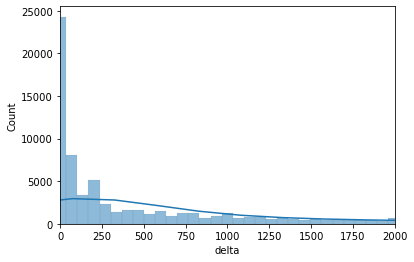

In [95]:
%matplotlib inline
df = pd.DataFrame(a, columns=['trdTime','ask','price'])
df = df[df['trdTime'] >= 93000000000000]
df = df[df['trdTime'] < 145700000000000]
df['delta'] = df['price'] - df['ask'] 
#df['delta'] = df['ask'] - df['price']
import seaborn as sns
import matplotlib.pyplot as plt
fig = sns.histplot(df['delta'],kde=True)
fig.set_xlim([0,1000])

Text(0, 0.5, 'count')

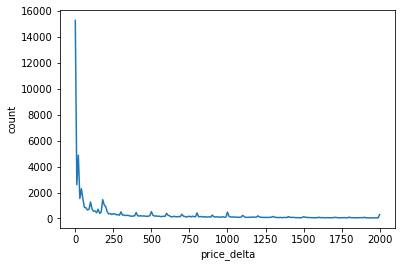

In [96]:
df = df[df['delta']<=1000]
df = df[df['delta']>=0]
x = df.groupby('delta').size()
fig = plt.figure()
plt.plot(x.index,x.values)
plt.xlabel('price_delta')
plt.ylabel('count')

(0.0, 1000.0)

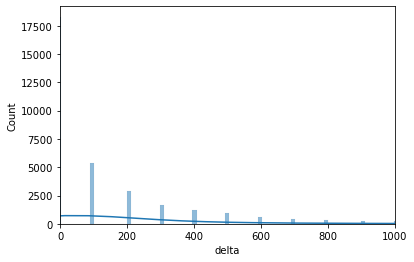

In [85]:
df = pd.DataFrame(b, columns=['trdTime','bid','price'])
df = df[df['trdTime'] >= 93000000000000]
df = df[df['trdTime'] < 145700000000000]
#df['delta'] = df['price'] - df['ask'] 
df['delta'] = df['bid'] - df['price']
import seaborn as sns
import matplotlib.pyplot as plt
fig = sns.histplot(df['delta'],kde=True)
fig.set_xlim([0,1000])

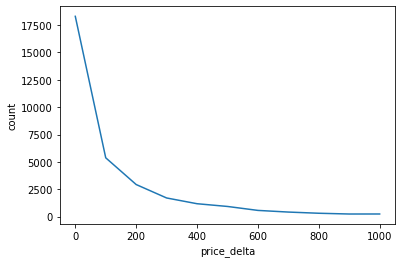

In [86]:
df = df[df['delta']<=1000]
df = df[df['delta']>=0]
x = df.groupby('delta').size()
fig = plt.figure()
plt.plot(x.index,x.values)
plt.xlabel('price_delta')
plt.ylabel('count')
plt.savefig(str(ins)+'.png')

In [11]:
def get_current_vol(timestamp=93005 * 1e09):
    OrderQue_test = OrderQue(str(ins))
    for data_i in getMkDataMult(dataStreamMap):
        OrderQue_test.handle(data_i)
        if OrderQue_test.mktTime >= timestamp:
            return OrderQue_test.bid.max_key(),OrderQue_test.bidVol,OrderQue_test.ask.min_key(),OrderQue_test.askVol
bid,bidVol,ask,askVol = get_current_vol(93010 * 1e09)

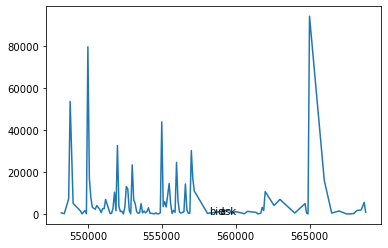

In [35]:
def current_vol_plot(bid,bidVol,ask,askVol,alpha=1e-04):
    '''
    :param price: bid price/ask price
    :param vol: OrderQue.bidVol/OrderQue.askVol
    :param alpha:
    :return:
    '''
    bid_df = pd.Series(bidVol)
    bid_df = bid_df[bid_df!=0]
    bid_df.sort_index(inplace=True)
    ask_df = pd.Series(askVol)
    ask_df = ask_df[ask_df!=0]
    ask_df.sort_index(inplace=True)
    df = pd.concat([bid_df,ask_df])
    df = df[df.index<=ask+10000]
    df = df[df.index>=bid-10000]
    df.sort_index(inplace=True)
    plt.plot(df.index,df.values)
    #plt.xlim(bid-10000,ask+10000)
    plt.annotate(text='ask',xy=(ask,0))
    plt.annotate(text='bid',xy=(bid,0))
    return df
df = current_vol_plot(bid,bidVol,ask,askVol,alpha=1e-04)

In [43]:
def get_trd_vol(timestamp=93005 * 1e09,timedelta = 5*1e09):
    bid,bidVol,ask,askVol = get_current_vol(timestamp)
    timestamp1 = timestamp + timedelta
    OrderQue_test = OrderQue(str(ins))
    trd_vol = {}
    for data_i in getMkDataMult(dataStreamMap):
        OrderQue_test.handle(data_i)
        if OrderQue_test.mktTime >= timestamp and data_i[0]==1:
            transRc = data_i[1:][:10]
            type_i = transRc[6]
            vol = transRc[4]
            price = transRc[3]
            if type_i==1:
                if price in trd_vol:
                    trd_vol[price] += vol
                else:
                    trd_vol[price] = vol
        if OrderQue_test.mktTime >= timestamp1:
            return OrderQue_test.lastPrice,trd_vol
lastPrice,trd_vol = get_trd_vol()

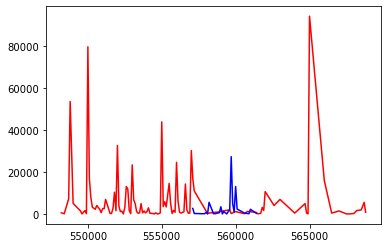

In [46]:
def current_trd_plot(lastPrice, trd_vol,df):
    plt.plot(df.index,df.values,label='order',color='red')
    df = pd.Series(trd_vol)
    df.sort_index(inplace=True)
    #plt.annotate(text='ask',xy=(ask,0))
    #plt.annotate(text='bid',xy=(bid,0))
    plt.plot(df.index,df.values,label='trans',color='blue')
current_trd_plot(lastPrice, trd_vol,df)

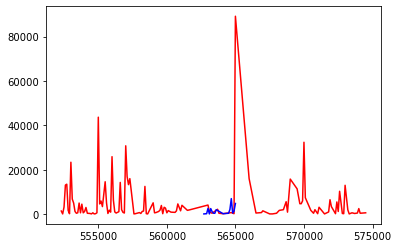

In [57]:
def ord_trans(timestamp=93005 * 1e09,timedelta = 5*1e09):
    timestamp1 = timestamp + timedelta
    OrderQue_test = OrderQue(str(ins))
    trd_vol = {}
    c = 0
    for data_i in getMkDataMult(dataStreamMap):
        OrderQue_test.handle(data_i)
        if OrderQue_test.mktTime >= timestamp and c==0:
            bid,bidVol,ask,askVol = \
            OrderQue_test.bid.max_key(),OrderQue_test.bidVol,OrderQue_test.ask.min_key(),OrderQue_test.askVol
            c = 1
        if OrderQue_test.mktTime >= timestamp and data_i[0]==1:
            transRc = data_i[1:][:10]
            type_i = transRc[6]
            vol = transRc[4]
            price = transRc[3]
            if type_i==1:
                if price in trd_vol:
                    trd_vol[price] += vol
                else:
                    trd_vol[price] = vol
        if OrderQue_test.mktTime >= timestamp1:
            break
    bid_df = pd.Series(bidVol)
    bid_df = bid_df[bid_df!=0]
    bid_df.sort_index(inplace=True)
    ask_df = pd.Series(askVol)
    ask_df = ask_df[ask_df!=0]
    ask_df.sort_index(inplace=True)
    df = pd.concat([bid_df,ask_df])
    df = df[df.index<=ask+10000]
    df = df[df.index>=bid-10000]
    df.sort_index(inplace=True)
    plt.plot(df.index,df.values,label='order',color='red')
    df = pd.Series(trd_vol)
    df.sort_index(inplace=True)
    plt.plot(df.index,df.values,label='trans',color='blue')
ord_trans(timestamp=93020 * 1e09)

In [75]:
def trans():
    data=[]
    OrderQue_test = OrderQue(str(ins))
    for data_i in getMkDataMult(dataStreamMap):
        OrderQue_test.handle(data_i)
        if data_i[0]==1:
            orderRc = data_i[1:][:8]
            orderID = orderRc[-1]
            time_i = orderRc[1]  # trdTime
            locTime = orderRc[2]  # recvTime
            type_i = orderRc[-2]
            bsFlag = orderRc[-3]
            price = orderRc[3]
            vol_i = orderRc[4]
            if type_i == 1 and time_i>=93000*1e09 and time_i<145700*1e09:
                data.append([time_i,0])      
    return np.array(data)
data=trans()

In [58]:
from MHP import *
P = MHP()

In [ ]:
P.EM(Ahat=P.alpha,mhat=P.mu,omega=P.omega,seq=data)